# Tangent Patch

In [3]:
import torch
import numpy as np
import torch.nn.functional as F

- model: Conv2d -> Linear(in=256, out=768)
- recover depth map: [scatter mean](https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html)(u, v), visualize and test with rgb
- batch grid sample:
  - N: number of batches, P: number of patches
  - Input: img = N x CHW, grids = N x (P x 16) x 16 x 2
  - Output: N x (P x 16) x 16 - reshape -> N x P x 16 x 16

In [4]:
class ToTangentPatch:
    def __init__(self, fov, patch_dim, npatch):
        # Create sphereical grid in Cartesian coordinates
        assert fov < np.pi and fov > 0.0, f'Invalid FOV: got {fov} rad.'
        amp = torch.tan(torch.as_tensor(fov / 2.0, dtype=torch.float32))
        tan_ax = torch.linspace(-amp, amp, steps=patch_dim)
        tan_y, tan_x = torch.meshgrid(-tan_ax, tan_ax)

        # Convert grid to polar coordinates
        theta = torch.atan2(tan_x, torch.as_tensor(1.0))
        phi = torch.atan2(tan_y, torch.sqrt(tan_x ** 2.0 + 1.0))

        # Create rotated grids
        u = 2.0 * np.pi * torch.rand(npatch, 1, 1)
        v = torch.asin(2.0 * torch.rand(npatch, 1, 1) - 1.0)
        theta, phi = theta + u, phi + v
        while torch.any(theta > np.pi):
            theta[theta > np.pi] -= 2.0 * np.pi
        while torch.any(theta < -np.pi):
            theta[theta < -np.pi] += 2.0 * np.pi

        # Scale grids to [-1, 1]
        theta = theta / np.pi
        phi = -phi / np.pi * 2.0
        self.grid = torch.stack([theta, phi], dim=-1)

        self.npd = (npatch, patch_dim)

    def __call__(self, x):
        grid = self.grid.flatten(0, 1).expand(x.shape[0], -1, -1, -1)
        tan_patch = F.grid_sample(x, grid, align_corners=True)  # (N, C, PxD, D)

        tan_patch = tan_patch.unflatten(2, self.npd)  # (N, C, P, D, D)
        tan_patch = tan_patch.transpose(1, 2)         # (N, P, C, D, D)

        return tan_patch

Create grids (theta, phi + offsets u, v)
Scale grids to [-1, 1] -> sample image with grids
Scale grids to image coordinate [0, 399] x [0, 1023]

In [4]:
import torchinfo
from model import ViTBackbone

In [5]:
model = ViTBackbone([18, 48], dropout=False)
torchinfo.summary(model, [1, 3, 16*18, 16*48])

Layer (type:depth-idx)                   Output Shape              Param #
ViTBackbone                              --                        --
├─Normalize: 1-1                         [1, 3, 288, 768]          --
├─VisionTransformer: 1                   --                        --
│    └─PatchEmbed: 2                     --                        --
│    │    └─Conv2d: 3-1                  [1, 768, 18, 48]          590,592
├─Upsample: 1-2                          [1, 768, 18, 48]          --
├─VisionTransformer: 1                   --                        --
│    └─Sequential: 2                     --                        --
│    │    └─Block: 3-2                   [1, 865, 768]             7,087,872
│    │    └─Block: 3-3                   [1, 865, 768]             7,087,872
│    │    └─Block: 3-4                   [1, 865, 768]             7,087,872
│    │    └─Block: 3-5                   [1, 865, 768]             7,087,872
│    │    └─Block: 3-6                   [1, 865, 76

In [5]:
torch.manual_seed(3985)
N = 256
patch_dim = 16

In [6]:
# FOV x number of horizontal patches = a 360 degree view
# nhp * (nhp * 400 / 1024) = N -> nhp = sqrt(N / (400 / 1024))
fov = 2.0 * np.pi / np.sqrt(N * 1024.0 / 400.0)

In [7]:
to_tan_patch = ToTangentPatch(fov, patch_dim, N)

In [8]:
to_tan_patch.grid.shape

torch.Size([256, 16, 16, 2])

In [10]:
to_tan_patch.grid[:5, 1, 1, :]

tensor([[-0.4680, -0.6329],
        [-0.1112, -0.6883],
        [ 0.0723,  0.2249],
        [ 0.8895, -0.6948],
        [-0.4293, -0.6035]])

In [9]:
import torch
import numpy as np
import torchvision.transforms as T
from datasets import MP3dPSP

In [10]:
ds = MP3dPSP('val')
tensor2pil = T.ToPILImage()

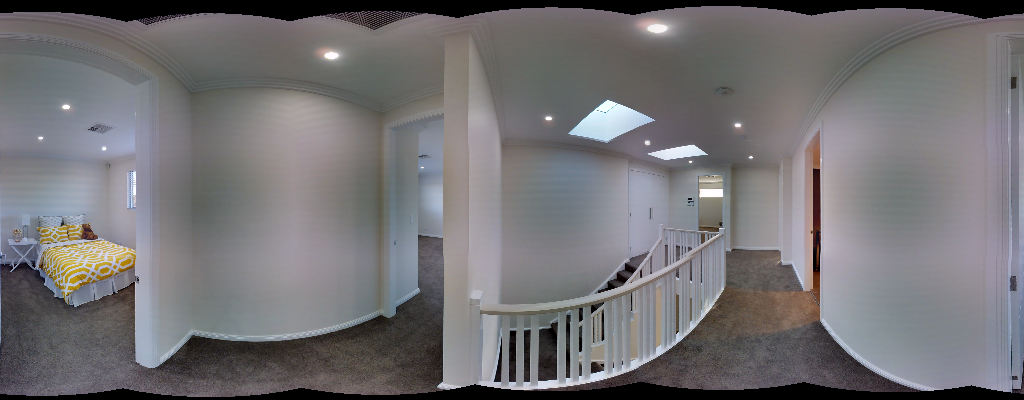

In [11]:
x = ds[2][0]
tensor2pil(x)

In [14]:
xb = x.unsqueeze(0)
imgs = to_tan_patch(xb)
# imgs = imgs.squeeze(0)

In [18]:
from torch import nn

In [38]:
xx = torch.rand(1, 864, 3, 16, 16)

In [46]:
class Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 768, 16)
    def forward(self, x):
        x = x.squeeze(0)
        x = self.conv(x)
        x = x.squeeze().unsqueeze(0)
        return x

conv = Conv()
y = conv(xx)

In [47]:
class Lin(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(3 * 16 * 16, 768)
    def forward(self, x):
        x = x.flatten(2)
        x = self.lin(x)
        return x

lin = Lin()
z = lin(xx)

In [45]:
y.shape, z.shape, torch.allclose(y, z)

(torch.Size([1, 864, 768]), torch.Size([1, 864, 768]), False)

In [ ]:
# 1, 864, 3, 16, 16 -> 768, 864

In [15]:
imgs.shape

torch.Size([1, 256, 3, 16, 16])

In [17]:
import matplotlib.pyplot as plt
rng = np.random.default_rng(3985)

In [ ]:
idxs = rng.choice(N, 25)
img_np = imgs.permute(0, 2, 3, 1).numpy()

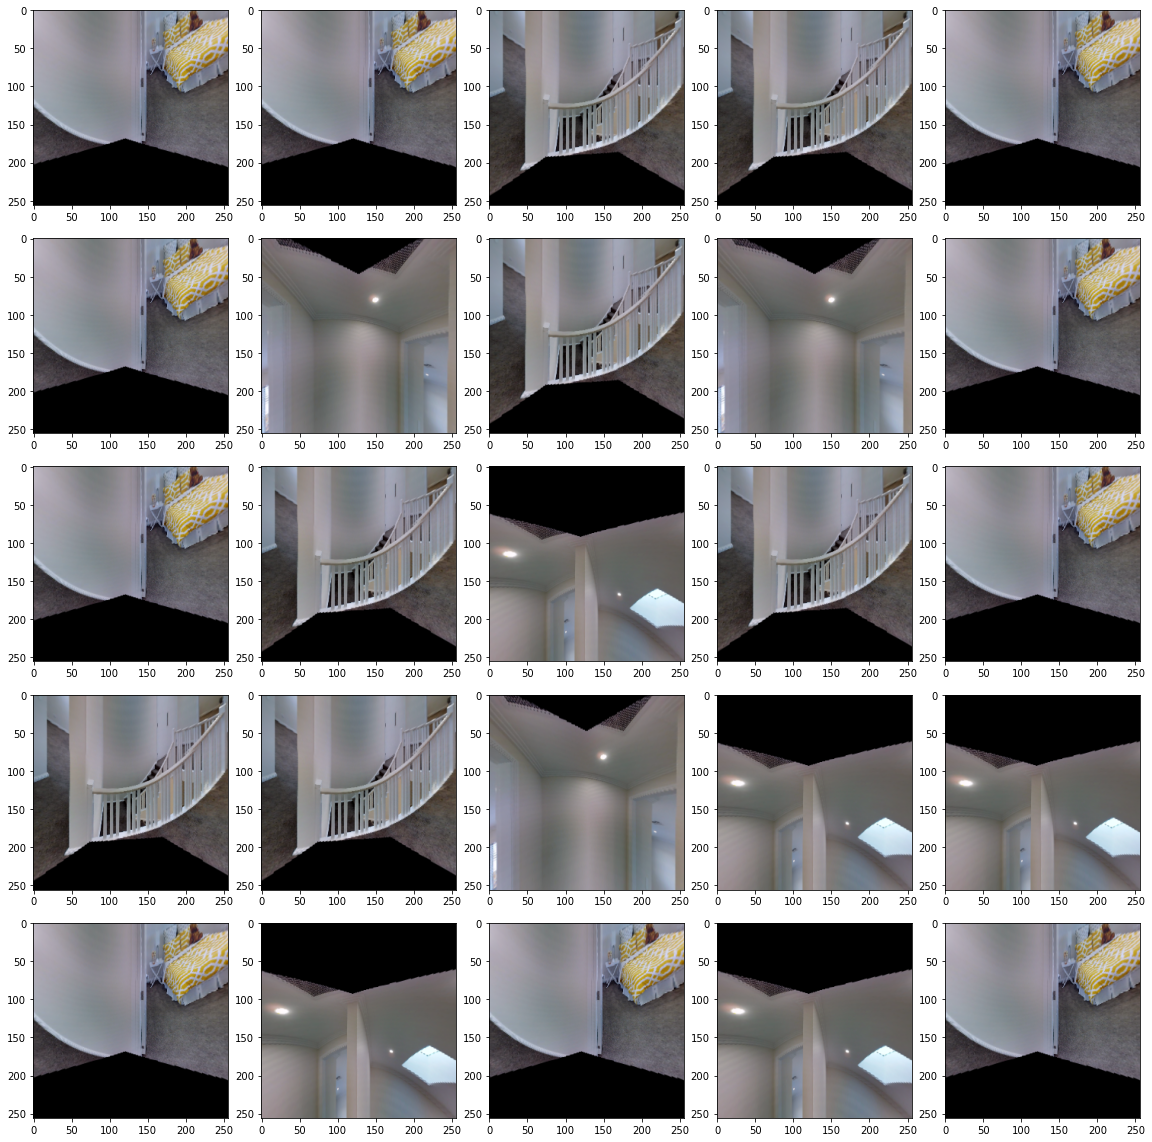

In [26]:
fig, axs = plt.subplots(5, 5, figsize=[16, 16])
for ax, idx in zip(axs.flatten(), idxs):
    ax.imshow(img_np[idx])
fig.tight_layout()

## Testing

In [61]:
def polar_grid(fov, npoint):
    amp = torch.tan(fov / 2.0)
    tan_ax = torch.linspace(-amp, amp, steps=npoint, dtype=torch.float32)
    tan_y, tan_x = torch.meshgrid(-tan_ax, tan_ax)

    theta = torch.atan2(tan_x, torch.as_tensor(1.0))
    phi = torch.atan2(tan_y, torch.sqrt(tan_x ** 2.0 + 1.0))

    return theta, phi

def rotate_grid(theta, phi, u, v):
    theta, phi = theta + u, phi + v

    while torch.any(theta > np.pi):
        theta[theta > np.pi] -= 2.0 * np.pi
    while torch.any(theta < -np.pi):
        theta[theta < -np.pi] += 2.0 * np.pi

    return theta, phi

def to_sample_range(theta, phi):
    theta = theta / np.pi
    phi = -phi / np.pi * 2.0
    return torch.stack([theta, phi], dim=-1)

In [62]:
fov_t = torch.as_tensor(fov)
theta, phi = polar_grid(fov_t, patch_dim)

In [63]:
u = 2.0 * np.pi * torch.rand(N, 1, 1)
v = torch.asin(2.0 * torch.rand(npatch, 1, 1) - 1.0)

In [65]:
theta, phi = map(lambda x: x.expand(N, -1, -1), (theta, phi))
theta, phi = rotate_grid(theta, phi, u, v)
grids = to_sample_range(theta, phi)
imgs = F.grid_sample(x.expand(N, -1, -1, -1), grids, align_corners=True)

## Uniform Sampling on A Sphere

Let $\theta \in [-\pi, \pi]$, $\phi \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ 
and the infinitesmal area of a unit sphere $dA = cos \phi d\theta \cdot d\phi$  

The probability of an area being sampled, $g$, is uniform, and $\int\int g dA = 1$. 
Thus, $$g \int\int dA = g \cdot 4\pi = 1 \implies g = \frac{1}{4\pi}$$  

Every $dA$ sampled corresponds to a set of $(\theta, \phi)$, 
whose probability of being sampled is $f(\theta, \phi)$, 
so $$\frac{1}{4\pi} dA = \frac{1}{4\pi} cos \phi d\theta d\phi = f(\theta, \phi) d\theta d\phi
\implies f(\theta, \phi) = \frac{1}{4\pi} cos \phi$$

The probability of $\theta$ being sampled is
$$f(\theta) = \int^{\frac{\pi}{2}}_{-\frac{\pi}{2}} f(\theta, \phi) d\phi
            = \int^{\frac{\pi}{2}}_{-\frac{\pi}{2}} \frac{1}{4\pi} cos \phi d\phi
            = \frac{1}{2\pi}$$

The probability of $\phi$ being sampled is
$$f(\phi) = \int^{\pi}_{-\pi} f(\theta, \phi) d\theta
          = \int^{\pi}_{-\pi} \frac{1}{4\pi} cos \phi d\theta
          = \frac{cos \phi}{2}$$

Using [inverse transform sampling](http://corysimon.github.io/articles/uniformdistn-on-sphere/), 
we know that $\phi \sim F^{-1}(U)$,  
where $U$ is a uniform random variable in $[0, 1]$, and $F(\phi)$ is the probability cumulative function.  
Since 
$$F(\phi) = \int^{\pi}_{-\pi} f(\phi) d\phi
          = \int^{\pi}_{-\pi} \frac{cos \phi}{2} d\phi
          = \frac{1}{2} (sin \phi + 1)$$
Hence, 
$$F^{-1}(\phi) = arcsin (2 \phi - 1)$$

In [13]:
import torch
import numpy as np
import plotly.graph_objects as go

In [33]:
torch.manual_seed(3985)
N = 500

In [34]:
theta = 2.0 * np.pi * torch.rand(N)
phi = torch.asin(2.0 * torch.rand(N) - 1.0)

In [35]:
sphere = go.Scatter3d(
    x=torch.sin(phi) * torch.cos(theta),
    y=torch.sin(phi) * torch.sin(theta),
    z=torch.cos(phi),
    mode='markers', marker={'size': 3}
)
fig = go.Figure(data=[sphere])
fig.show()